In [10]:
!pip install git+https://github.com/carnotresearch/cr-sparse.git
!pip install jax jaxlib librosa matplotlib


/usr/local/Caskroom/miniforge/base/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/carnotresearch/cr-sparse.git to /private/var/folders/3r/v0kpycs97914_12gzf1trl4r0000gp/T/pip-req-build-feevamzf
  Running command git clone --filter=blob:none --quiet https://github.com/carnotresearch/cr-sparse.git /private/var/folders/3r/v0kpycs97914_12gzf1trl4r0000gp/T/pip-req-build-feevamzf
  Resolved https://github.com/carnotresearch/cr-sparse.git to commit be3c74a96df671d86ea24ee5d029da5d07fa2512
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [11]:
# Read and process audios
import os
import librosa
import jax.numpy as jnp

folder = "./dataset/test_data"
sample_length = 256  # Must match dictionary size

signals = []

for file in os.listdir(folder):
    if file.endswith(".wav"):
        y, sr = librosa.load(os.path.join(folder, file), sr=None)
        if len(y) >= sample_length:
            y = y[:sample_length]  # Take the first 256 samples
            signals.append(jnp.array(y))

print(f"Loaded {len(signals)} signals")

Loaded 10 signals


In [12]:
#  Construct the Dirac-Cosine dictionary
import cr.sparse.dict as crdict

M = sample_length  # dimension of signal
Phi = crdict.dirac_cosine_basis(M)  # shape: (256, 512)

In [22]:
Phi

Array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.2500000e-02,  6.2500000e-02,  6.2500000e-02],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
        -8.8346757e-02, -8.8373378e-02, -8.8386685e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00, ...,
         8.8222012e-02,  8.8328458e-02,  8.8381693e-02],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.1215175e-03,  4.8782388e-03, -1.6283562e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.4221796e-03, -3.2515426e-03,  1.0843338e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.7123697e-03,  1.6291405e-03, -5.4566615e-04]], dtype=float32)

In [20]:
# Sparse recovery with Orthogonal Matching Pursuit (OMP)
from cr.sparse import opt
import cr.sparse.pursuit.omp

# Sparsity level
K = 5  # Adjust depending on your signal

# Solve the sparse recovery problem using Orthogonal Matching Pursuit
solution = cr.sparse.pursuit.omp.solve(Phi, y, K)

# Reconstruct the sparse vector x_hat manually from indices and values
x_hat = jnp.zeros(Phi.shape[1])
x_hat = x_hat.at[solution.I].set(solution.x_I)

Residual energy: nan


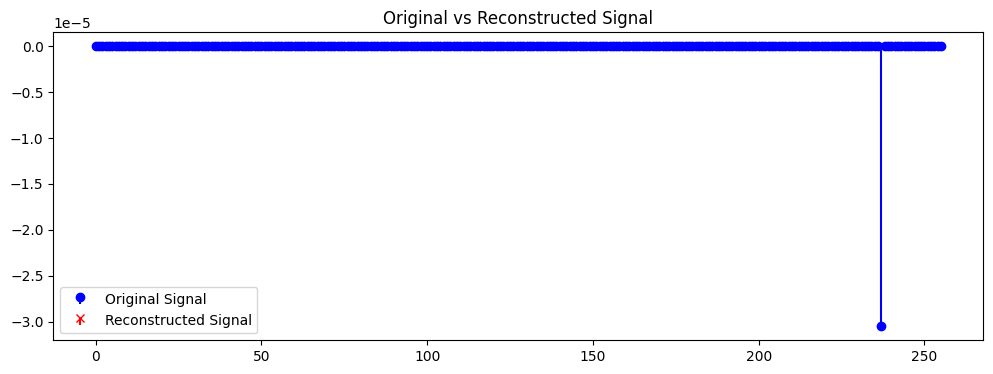

In [21]:
import matplotlib.pyplot as plt

# Reconstruct the signal
y_hat = Phi @ x_hat

# Calculate residual energy
residual_energy = jnp.sum((y - y_hat) ** 2)
print(f"Residual energy: {residual_energy:.4f}")

# Plot original and reconstructed signals
plt.figure(figsize=(12, 4))
plt.stem(y, label='Original Signal', markerfmt='bo', basefmt=" ", linefmt='b-')
plt.stem(y_hat, label='Reconstructed Signal', markerfmt='rx', basefmt=" ", linefmt='r--')
plt.title('Original vs Reconstructed Signal')
plt.legend()
plt.show()

In [23]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparseCoder

# Load the audio file
y, sr = librosa.load('./dataset/train_data/1727.wav', sr=None, offset=10, duration=5)

# Perform Short-Time Fourier Transform (STFT)
D = librosa.stft(y)
magnitude, phase = librosa.magphase(D)


In [24]:
D

array([[-7.0354617e-01+0.0000000e+00j, -5.1285541e-01+0.0000000e+00j,
        -7.9868592e-02+0.0000000e+00j, ...,
        -3.2474209e-02+0.0000000e+00j, -8.1615396e-02+0.0000000e+00j,
        -3.9822617e-01+0.0000000e+00j],
       [ 6.4217323e-01-2.9514354e-01j,  7.3791407e-02+5.2056628e-01j,
         7.2856672e-02-4.1276600e-02j, ...,
         5.5255987e-02-8.4154353e-02j,  3.9821889e-02+2.9827166e-02j,
        -1.3055943e-01-3.2399780e-01j],
       [-6.5797138e-01+8.2958025e-01j,  4.7373620e-01-4.7019273e-01j,
        -4.1003767e-01+2.4665999e-01j, ...,
        -1.7636197e+00-1.0316133e+00j, -1.0624297e+00+1.6282001e+00j,
         1.9018898e+00+7.8874630e-01j],
       ...,
       [ 1.5308753e-03-8.1962564e-05j, -5.4689933e-04+2.7946979e-04j,
        -3.9869893e-04-1.6337550e-04j, ...,
        -9.9908058e-05-4.3355256e-05j,  1.0948020e-04-3.7072608e-04j,
        -1.4051838e-03+2.5289485e-03j],
       [-1.5618457e-03-1.0616961e-04j, -3.3763773e-04+6.6903222e-04j,
        -1.0663891e-04

In [25]:
y, sr

(array([ 0.00180054, -0.00109863, -0.00439453, ..., -0.00701904,
        -0.00735474, -0.00753784], dtype=float32),
 44100)

In [26]:
magnitude, phase 

(array([[7.0354617e-01, 5.1285541e-01, 7.9868592e-02, ..., 3.2474209e-02,
         8.1615396e-02, 3.9822617e-01],
        [7.0675045e-01, 5.2577031e-01, 8.3736800e-02, ..., 1.0067362e-01,
         4.9753819e-02, 3.4931409e-01],
        [1.0588342e+00, 6.6746324e-01, 4.7851020e-01, ..., 2.0431790e+00,
         1.9441687e+00, 2.0589573e+00],
        ...,
        [1.5330678e-03, 6.1416789e-04, 4.3087400e-04, ..., 1.0890959e-04,
         3.8655367e-04, 2.8931163e-03],
        [1.5654500e-03, 7.4940198e-04, 1.3547839e-04, ..., 2.5298636e-04,
         3.2574849e-04, 2.7968064e-03],
        [1.7182257e-03, 1.1569421e-03, 3.9753632e-04, ..., 2.7089397e-04,
         1.2986302e-04, 2.5919976e-03]], dtype=float32),
 array([[-1.        +0.j        , -1.        +0.j        ,
         -1.        +0.j        , ..., -1.        +0.j        ,
         -1.        +0.j        , -1.        +0.j        ],
        [ 0.908628  -0.41760644j,  0.14034913+0.9901021j ,
          0.87006754-0.49293262j, ...,  0.54

In [27]:
# Create a dictionary of Fourier basis functions
n_basis = 100  # Number of basis functions
frequencies = np.linspace(20, 2000, n_basis)  
time = np.arange(magnitude.shape[1])
dictionary = np.array([np.cos(2 * np.pi * f * time / sr) for f in frequencies])


In [28]:
dictionary

array([[ 1.        ,  0.99999594,  0.99998376, ...,  0.34402761,
         0.34135064,  0.33867089],
       [ 1.        ,  0.99998376,  0.99993504, ..., -0.76329   ,
        -0.76695948, -0.77060405],
       [ 1.        ,  0.99996346,  0.99985385, ..., -0.86921329,
        -0.86495486, -0.86063322],
       ...,
       [ 1.        ,  0.9612617 ,  0.8480481 , ...,  0.99026807,
         0.91354546,  0.76604444],
       [ 1.        ,  0.96047236,  0.84501431, ...,  0.21000165,
        -0.0704671 , -0.34536505],
       [ 1.        ,  0.95967523,  0.84195308, ..., -0.84577534,
        -0.96165344, -0.99997463]])